# Imports & Configuration

In [23]:
import re
import logging
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from typing import Literal, List, Union
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

In [24]:
logging.basicConfig(level=logging.DEBUG, format="%(asctime)s %(levelname)s:%(message)s")
LOGGER = logging.getLogger(__name__)

# Read data

## Metric 370018 data

In [101]:
METRIC_ID = "370018"
data = pd.read_csv("../../.data/метрики_торгового_эквайринга.csv", usecols=["datetime", METRIC_ID], parse_dates=["datetime"])

print(data.shape)
display(data.head())

(1725120, 2)


,datetime,370018
0,2020-01-01 00:00:00,NaN
1,2020-01-01 00:01:00,NaN
2,2020-01-01 00:02:00,NaN
3,2020-01-01 00:03:00,NaN
4,2020-01-01 00:04:00,NaN


In [102]:
data.dtypes

datetime    datetime64[ns]
370018             float64
dtype: object

In [103]:
data["datetime"].agg(["min", "max"])

min   2020-01-01 00:00:00
max   2023-04-12 23:59:00
Name: datetime, dtype: datetime64[ns]

## Holidays

In [104]:
holidays = pd.read_excel("./holidays.xlsx", parse_dates=[0]).rename(columns={"Дата": "datetime"})

print(holidays.shape)
display(holidays.head())

(90, 5)


,datetime,Выходной / праздник,Предпраздничный / сокращенный,Перенос праздничного дня с выходного,Внеочередной рабочий день
0,2020-01-01,Новогодние каникулы,NaN,NaN,NaN
1,2020-01-02,Новогодние каникулы,NaN,NaN,NaN
2,2020-01-03,Новогодние каникулы,NaN,NaN,NaN
3,2020-01-04,Новогодние каникулы,NaN,NaN,NaN
4,2020-01-05,Новогодние каникулы,NaN,NaN,NaN


# Build the model

In [105]:
%mkdir tsforecast

A subdirectory or file tsforecast already exists.


In [106]:
class SymCalc:
    def __init__(self, method: Literal["dtw", "chi_square"] = "dtw", bin_size: str = 30, 
                 agg_f: Literal["median", "mean"] = "median") -> None:
        self.method = method
        self.bin_size = bin_size
        self.agg_f = agg_f
        
    def __call__(self, p: np.ndarray, q: np.ndarray) -> float:
        method = getattr(self, self.method)
        distance = method(p, q)
        return distance
    
    def chi_square(self, p: np.ndarray, q: np.ndarray) -> float:
        n_items = (len(p) + len(q)) // 2
        n_splits = self.calc_nsplits_(n_items=n_items, bin_size=self.bin_size)
        agg_f = getattr(np, "nan" + self.agg_f)

        bins_p = np.array_split(ary=p, indices_or_sections=n_splits)
        bins_p = np.array([agg_f(arr) for arr in bins_p])
        bins_p /= sum(bins_p)

        bins_q = np.array_split(ary=q, indices_or_sections=n_splits)
        bins_q = np.array([agg_f(arr) for arr in bins_q])
        bins_q /= sum(bins_q)

        statistic, _ = stats.chisquare(f_obs=bins_p, f_exp=bins_q, ddof=0)
        return statistic

    @staticmethod
    def calc_nsplits_(n_items: int, bin_size: int) -> int:
        return n_items // bin_size + (1 if n_items % bin_size else 0)

    @staticmethod
    def dtw(p: np.ndarray, q: np.ndarray) -> float:
        # create empty cost matrix
        cost_m = [[0 for _ in range(len(q))] for _ in range(len(p))]

        # заполним матрицу
        cost_m[0][0] = abs(p[0] - q[0])
        for col in range(0, len(q)):

            if col != 0:
                cost_m[0][col] = abs(p[0] - q[col]) + cost_m[0][col - 1]

            for row in range(1, len(p)):
                if col == 0:
                    cost_m[row][col] = abs(p[row] - q[col]) + cost_m[row - 1][col]
                    continue

                cost_m[row][col] = \
                    abs(p[row] - q[col]) + \
                    min(cost_m[row - 1][col - 1], cost_m[row - 1][col], cost_m[row][col - 1])
                
        # wraping path identification
        row, col = len(p) - 1, len(q) - 1
        d = []
        d.append(cost_m[row][col])

        while row > 0 or col > 0:
            neighbors = [float("inf"), float("inf"), float("inf")]
            if row > 0 and col > 0:
                neighbors[2] = cost_m[row - 1][col - 1]
            if row > 0:
                neighbors[1] = cost_m[row - 1][col]
            if col > 0:
                neighbors[0] = cost_m[row][col - 1]
            idx = np.argmin(neighbors) + 1
            step = (idx // 2, idx % 2)
            row, col = row - step[0], col - step[1]
            d.append (cost_m[row][col])     

        return sum(d) / len(d)


class Preprocessing:
    
    def __init__(self, roles: dict = {}, stages: List[Literal["extend_time", "interpolate"]] = ["extend_time", "interpolate"]) -> None:
        self.roles = {"datetime": "datetime", "value": "value", **roles}
        self.stages = stages

    def __call__(self, data: pd.DataFrame) -> pd.DataFrame:
        for stage in self.stages:
            method = getattr(self, stage)
            data = method(data)
        return data

    def extend_time(self, data: pd.DataFrame) -> pd.DataFrame:
        min_date, max_date = data[self.roles.get("datetime")].agg(["min", "max"])
        freq = int(data[self.roles.get("datetime")].diff().dropna().min().total_seconds() // 60)
        timeline = pd.date_range(start=min_date, end=max_date, freq="%sT" % freq)
        data = pd.DataFrame(data={self.roles.get("datetime"): timeline}) \
                 .merge(data.rename(columns=self.roles), on=self.roles.get("datetime"), how="left")
        return data

    def interpolate(self, data: pd.DataFrame) -> pd.DataFrame:
        data.loc[:, self.roles.get("value")] = data.loc[:, self.roles.get("value")] \
                                                   .interpolate(method="linear", limit_area="inside")
        return data
    

def rolling(arr: np.ndarray, window: int = 50, agg_f: Literal["mean", "median"] = "median"):
    agg_f = getattr(np, "nan" + agg_f)
    ans = np.full_like(a=arr, fill_value=1, dtype="float64")
    wc = window // 2 + (1 if window % 2 else 0) - 1
    for i in range(0, len(arr)):
        left_idx = max(0, i - wc)
        right_idx = left_idx + window

        if right_idx > len(arr):
            right_idx = len(arr)
            left_idx = right_idx - window

        value = agg_f(arr[left_idx:right_idx])
        ans[i] = value
    return ans

In [107]:
class TSModel:

    def __init__(self, h_size: int = 28, trend: Literal["linear", "polynomial"] = "linear", p_degree: int = 2,
                 roles: dict = {}, seasonal_type: Union[int, Literal["weekly", "daily"]] = "weekly", 
                 agg_f: Literal["mean", "median"] = "median", model_type: Literal["additive", "multiplicative"] = "additive",
                 holidays: pd.DataFrame = None, freq: int = 1, skip_holidays: bool = True, 
                 use_skaler: bool = True, scaler_window: int = 50, scaler_agg: Literal["mean", "median"] = "mean", 
                 fix_negative: bool = True, **kwargs) -> None:
        """
        :param h_size: размер обучающей выборки количестве значений (в днях)
        :param trend: тип детектируемого тренда ("linear" или "polynomial")
        :param p_degree: степень полинома в случае с полиномиальным трендом
        :param roles: названия колонок "datetime" и "value" в данных
        :param seasonal_type: тип максимальной сезонности (т.е. если присутствует и недельная, и дневная, то указывается недельная)
        :param agg_f: аггрегирующая функция при расчете сезонной компоненты
        :param model_type: тип модели (аддитивная или мультипликативная)
        """
        self.h_size = h_size
        self.trend = trend
        self.p_degree = p_degree
        self.roles = {"datetime": "datetime", "value": "value", **roles}
        self.seasonal_type = seasonal_type
        self.agg_f = agg_f
        self.model_type = model_type
        self.holidays = holidays
        self.freq = freq
        self.skip_holidays = skip_holidays
        self.use_skaler = use_skaler
        self.scaler_window = scaler_window
        self.scaler_agg = scaler_agg
        self.fix_negative = fix_negative

    def fit_predict(self, data: pd.DataFrame, horizon: int = 1, py_data: pd.DataFrame = None) -> pd.DataFrame:
        """
        :param data: исторические данные для настройки модели
        :param horizon: горизонт прогнозирования (в днях)
        """
        # настройка модели
        self.fit(data=data)

        # предсказание модели
        results = self.predict(horizon=horizon, py_data=py_data)
        return results

    def fit(self, data: pd.DataFrame) -> None:
        """
        :param data: DataFrame с колонками даты и значения
                     значения должны быть без пропусков в timeline
        """
        # первая дата для предсказания
        self.predict_from = data["datetime"].iloc[-1] + pd.DateOffset(minutes=self.freq)

        # количество данных для обучения
        self.h_size_items = int(self.h_size * (24 * 60) // self.freq)

        # если размер истории меньше, чем выставленный параметр размера истории
        # то корректируем
        self.h_size_items = min(len(data), self.h_size_items)

        # настраиваем тренд
        fit_data = data.iloc[-self.h_size_items:, :]  # обучающая выборка
        self.discard_mask = fit_data[self.roles.get("value")].isna().values
        if self.holidays is not None and self.skip_holidays:
            self.discard_mask |= fit_data[self.roles.get("datetime")].dt.normalize().isin(self.holidays["datetime"]).values
        y = fit_data[self.roles.get("value")].values
        detrended = self.fit_trend_(y=y)

        # настроим сезонность
        self.fit_seasonal_(y=detrended, timeline=fit_data[self.roles.get("datetime")])
        return
    
    def fit_trend_(self, y: np.ndarray) -> None:
        # инициализируем модель линейной регрессии
        self.lr = LinearRegression()
        x = self.trend_features_generation_()
        self.lr.fit(x[~self.discard_mask], y[~self.discard_mask])
        trend = self.lr.predict(x)

        if self.model_type == "additive":
            detrended = y - trend
        elif self.model_type == "multiplicative":
            detrended = y / trend
        else:
            raise ValueError("Wrong model type.")
        
        return detrended
    
    def trend_features_generation_(self, horizon: int = None) -> np.ndarray:
        """
        :param horizon: количество точек для прогнозирования (не дней)
        """
        if horizon is None:
            x = np.reshape(range(self.h_size_items), newshape=(-1, 1))
        elif isinstance(horizon, int) and horizon > 0:
            x = np.reshape(range(horizon), newshape=(-1, 1))
            x += self.h_size_items
        else:
            raise ValueError("Wrong horizon value (has to be integer greater than 0)")

        if self.trend == "polynomial":
            pf = PolynomialFeatures(degree=self.p_degree, include_bias=False)
            x = pf.fit_transform(x)
        
        return x
    
    def fit_seasonal_(self, y: np.ndarray, timeline: pd.Series) -> None:
        y_filtered = np.where(~self.discard_mask, y, np.nan)
        
        if isinstance(self.seasonal_type, int):
            sl = self.seasonal_type
            self.seasonal_groups = np.zeros(shape=(sl))
        elif isinstance(self.seasonal_type, str) and self.seasonal_type == "weekly":
            sl = 7 * 1440 // self.freq
            # считаем, что помимо недельной сезонности есть еще и дневная
            self.seasonal_groups = \
                timeline.iloc[-1:-sl - 1:-1] \
                        .groupby(by=timeline.iloc[-1:-sl - 1:-1].dt.normalize()) \
                        .ngroup() \
                        .values
        elif isinstance(self.seasonal_type, str) and self.seasonal_type == "daily":
            sl = 1440 // self.freq
            self.seasonal_groups = np.zeros(shape=(sl))
        else:
            raise ValueError("Wrong seasonal component.")
        
        if self.h_size_items % sl:
            self.seasonal = np.insert(arr=y_filtered.astype("float"), obj=[0]*(sl - self.h_size_items % sl), values=np.nan)
            self.seasonal = np.reshape(self.seasonal, newshape=(sl, -1), order="F")
            agg_f = getattr(np, "nan" + self.agg_f)
        else:
            self.seasonal = np.reshape(y_filtered, newshape=(sl, -1), order="F")
            agg_f = getattr(np, "nan" + self.agg_f)
            
        self.seasonal = agg_f(self.seasonal, axis=1)
        return
    
    def predict(self, horizon: int = 1, py_data: pd.DataFrame = None) -> pd.DataFrame:
        """
        :param horizon: горизонт прогнозирования (в днях)
        :param py_data:
        """
        # время предсказания
        pred_from = self.predict_from
        pred_to   = self.predict_from + pd.Timedelta(minutes=horizon*1440 - 1)
        pred_tl   = pd.date_range(start=pred_from, 
                                  end  =pred_to, 
                                  freq ="%sT" % self.freq)

        # предсказываем тренд
        trend = self.predict_trend_(horizon=horizon)

        # предсказываем сезонную компоненту
        seasonal = self.predict_seasonal_(seasonal_comp=self.seasonal, freq=self.freq, horizon=horizon)
        
        # скорректируем прогноз сезонной компоненты в соответствии с праздниками
        if py_data is not None and self.holidays is not None:
            # только те праздники, которые попадают в период прогнозирования
            filtered_holidays = \
                self.holidays[self.holidays["datetime"].between(left =pred_from,
                                                                right=pred_to)]
            filtered_holidays = \
                filtered_holidays.dropna(axis=0, subset=["Выходной / праздник"], how="any")

            # если какие-то праздики попадаю в указанных период, то корректируем сезонную компоненту для них
            if not filtered_holidays.empty:
                # настраиваем модель за предыдущий год и считаем прогноз
                py_train_data = py_data[:-1440*horizon//self.freq]
                self.py_model = TSModel(**self.__dict__)
                py_forecast = self.py_model.fit_predict(data=py_train_data, horizon=horizon)

                # определяем смещение дней недели в сезонной компоненте для прошлого года и для текущего
                shift = self.predict_from.weekday() - self.py_model.predict_from.weekday()
                LOGGER.debug("Смещение дней недели в сезонных компонентах прошлого года и текущего: %s" % shift)

                # итерируемся по празникам
                for _, holiday in filtered_holidays.iterrows():
                    # определяем дату праздника в прошлом году
                    holiday_date = holiday["datetime"]
                    py_holiday_date = holiday_date - pd.DateOffset(years=1)
                    LOGGER.debug("Праздничный день: %s" % holiday_date)

                    # рельные значения во время праздника в прошлом году
                    py_holiday_mask = \
                        (py_forecast[self.roles.get("datetime")].dt.normalize() == py_holiday_date).values
                    py_holiday_actual = \
                        py_data.iloc[-1440*horizon//self.freq:].loc[py_holiday_mask, self.roles.get("value")].values

                    # удаляем тренд из реальных значений праздника в прошлом году
                    py_trend = py_forecast.loc[py_holiday_mask, "trend"].values
                    py_detrended = py_holiday_actual / py_trend

                    # ищем ближайший день из сезонной компоненты для данного праздника в прошлом году
                    sc = SymCalc(method="chi_square")
                    best_seasonal_idx = 0
                    best_similarity = float("inf")
                    for seasonal_idx in np.unique(self.py_model.seasonal_groups):
                        similarity = sc(p=py_detrended, q=self.py_model.seasonal[self.py_model.seasonal_groups == seasonal_idx])
                        LOGGER.debug("Значение близости для дня с индексом {} из сезонной компоненты " \
                                     "(прошлый год): {:.5f}".format(seasonal_idx, similarity))
                        
                        if similarity < best_similarity:
                            best_similarity = similarity
                            best_seasonal_idx = seasonal_idx
                    
                    LOGGER.debug("Лучший день из сезонной компоненты в прошлом году: {} " \
                                 "(значение близости: {:.5f})".format(best_seasonal_idx, best_similarity))
                    
                    curr_idx = np.roll(np.unique(self.seasonal_groups), shift=-shift)[best_seasonal_idx]
                    LOGGER.debug("Аналогичный день из сезонной компоненты в текущем году: %s" % (curr_idx))

                    # заменяем сезонную компоненту для праздника в текущем году
                    curr_mask = (pred_tl.normalize() == holiday_date)
                    seasonal[curr_mask] = self.seasonal[self.seasonal_groups == curr_idx]

                    # определим скалирующий коэффициент и сгладим его
                    if self.use_skaler:
                        with np.errstate(divide='ignore', invalid='ignore'):
                            scaler = py_detrended / self.py_model.seasonal[self.py_model.seasonal_groups == best_seasonal_idx]
                        scaler = np.where(np.isfinite(scaler), scaler, 1)
                        scaler = rolling(arr=scaler, window=self.scaler_window, agg_f=self.scaler_agg)
                        seasonal[curr_mask] *= scaler
                    
        # объединяем прогнозы компонент
        if self.model_type == "additive":
            forecast = seasonal + trend
        elif self.model_type == "multiplicative":
            forecast = seasonal * trend
        else:
            raise ValueError("Wrong model type.")
        
        # Коррекция отрицательных значений (если такие имеются)
        if self.fix_negative:
            forecast = np.where(forecast >= 0, forecast, 0)
        
        results = pd.DataFrame(data={"datetime": pred_tl, "forecast": forecast, "trend": trend, "seasonal": seasonal})
        return results
    
    def predict_trend_(self, horizon: int = 1) -> np.ndarray:
        """
        :param horizon: горизонт прогнозирования (в днях)
        """
        x = self.trend_features_generation_(horizon=int(horizon * 1440 // self.freq))
        trend = self.lr.predict(x)
        return trend

    @staticmethod
    def predict_seasonal_(seasonal_comp: np.ndarray, horizon: int = 1, freq: int = 1) -> np.ndarray:
        """
        :param horizon: горизонт прогнозирования (в днях)
        """
        n_points = int(horizon*1440 // freq)
        if n_points > len(seasonal_comp):
            n_rep = n_points // len(seasonal_comp) + (1 if n_points % len(seasonal_comp) else 0)
            seasonal = np.tile(seasonal_comp, n_rep)[:n_points]
        else:
            seasonal = seasonal_comp[:n_points]
        return seasonal


2023-04-26 16:51:05,283 DEBUG:Смещение дней недели в сезонных компонентах прошлого года и текущего: 1
2023-04-26 16:51:05,285 DEBUG:Праздничный день: 2023-02-23 00:00:00
2023-04-26 16:51:05,295 DEBUG:Значение близости для дня с индексом 0 из сезонной компоненты (прошлый год): 0.05468
2023-04-26 16:51:05,304 DEBUG:Значение близости для дня с индексом 1 из сезонной компоненты (прошлый год): 0.05070
2023-04-26 16:51:05,312 DEBUG:Значение близости для дня с индексом 2 из сезонной компоненты (прошлый год): 0.00841
2023-04-26 16:51:05,321 DEBUG:Значение близости для дня с индексом 3 из сезонной компоненты (прошлый год): 0.00935
2023-04-26 16:51:05,329 DEBUG:Значение близости для дня с индексом 4 из сезонной компоненты (прошлый год): 0.05616
2023-04-26 16:51:05,338 DEBUG:Значение близости для дня с индексом 5 из сезонной компоненты (прошлый год): 0.05474
2023-04-26 16:51:05,347 DEBUG:Значение близости для дня с индексом 6 из сезонной компоненты (прошлый год): 0.05357
2023-04-26 16:51:05,348 D

(1440, 4)


,datetime,forecast,trend,seasonal
0,2023-02-23 00:00:00,189.167025,860.034236,0.219953
1,2023-02-23 00:01:00,219.570144,860.036327,0.255303
2,2023-02-23 00:02:00,409.224198,860.038419,0.475821
3,2023-02-23 00:03:00,223.210569,860.040510,0.259535
4,2023-02-23 00:04:00,208.015290,860.042602,0.241866


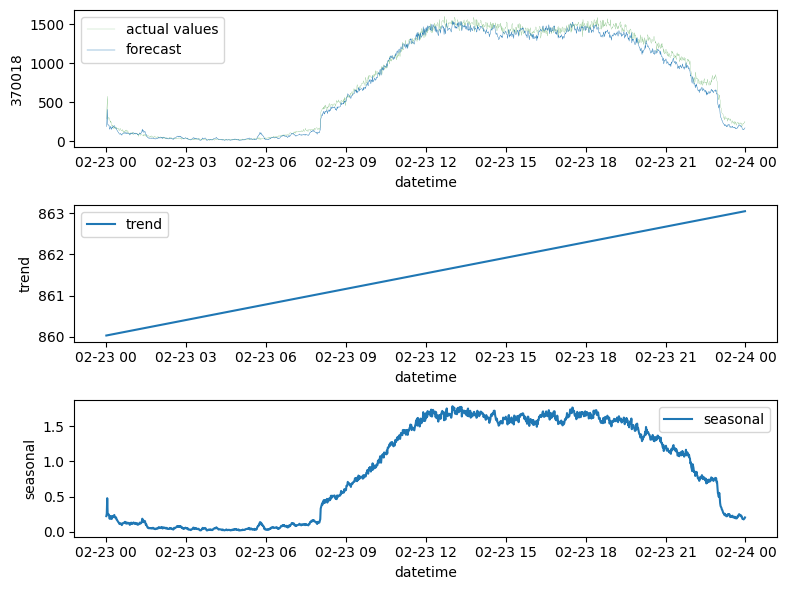

In [108]:
horizon = 1
pred_from = pd.Timestamp("2023-02-23 00:00:00")
pred_to = pred_from + pd.Timedelta(days=horizon, minutes=-1)

train_data = data[(data["datetime"] < pred_from)]
prev_year  = data[(data["datetime"] < pred_from + pd.DateOffset(years=-1, days=horizon))]
test_data  = data[(data["datetime"] >= pred_from) & (data["datetime"] <= pred_to)]
roles = {"value": METRIC_ID}

# выполняем предобработку данных
pr = Preprocessing(roles=roles, stages=["extend_time"])
train_data = pr(train_data)
prev_year  = pr(prev_year)

# построение прогноза
model = TSModel(roles=roles, 
                seasonal_type="weekly", 
                agg_f="median", 
                model_type="multiplicative", 
                trend="linear", 
                holidays=holidays, 
                skip_holidays=True,
                use_skaler=True, 
                scaler_window=10)
forecast = model.fit_predict(data=train_data, horizon=horizon, py_data=prev_year)

print(forecast.shape)
display(forecast.head())

fig, (ax_forecast, ax_trend, ax_seasonal) = plt.subplots(nrows=3, ncols=1, figsize=(8, 2*3))
sns.lineplot(data=test_data, x="datetime", y=METRIC_ID,  ax=ax_forecast, label="actual values", c="green", lw=0.1)
sns.lineplot(data=forecast,  x="datetime", y="forecast", ax=ax_forecast, label="forecast", lw=0.3)
sns.lineplot(data=forecast,  x="datetime", y="trend",    ax=ax_trend,    label="trend")
sns.lineplot(data=forecast,  x="datetime", y="seasonal", ax=ax_seasonal, label="seasonal")
fig.tight_layout();